In [43]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly_express as px
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph
import source.plot_helpers as plot

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Data

In [2]:
data = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(data))
data.head()

544


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [3]:
hlp.pandas.numeric_summary(data)

In [44]:
px.scatter(
    data,
    x='weight',
    y='height',
    color=data['male'].apply(lambda x: 'male' if x else 'female'),
    trendline='lowess',
    labels={'color': 'Sex'},
    title=plot.px_title("Weight vs Height", "by Sex")
)

In [45]:
px.histogram(
    data,
    x='height',
    color=data['male'].apply(lambda x: 'male' if x else 'female'),
    labels={'color': 'Sex'},
    title=plot.px_title("Height (Adults only)", "by Sex")
)

---

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer

def transform_is_adult(X):
    values = X[['age']].apply(lambda v: 1 if (v >= 18).all() else 0, axis=1).values
    return np.reshape(values, (-1, 1))

pipeline = make_column_transformer(
    (make_pipeline(StandardScaler(), PolynomialFeatures(3, include_bias=False)), ['weight']),
    (FunctionTransformer(func=transform_is_adult), ['age']),
    ('passthrough', ['male']),
)

# pipeline = make_pipeline(
#     StandardScaler(),
#     make_column_transformer((PolynomialFeatures(3, include_bias=False), ['weight']))
# )

X = data.copy().drop(columns='height')
y = data['height']

print(X.head())
X = pipeline.fit_transform(X)
X.shape


      weight   age  male
0  47.825606  63.0     1
1  36.485807  63.0     0
2  31.864838  65.0     0
3  53.041914  41.0     1
4  41.276872  51.0     0


(544, 5)

In [7]:
print(data['age'].iloc[:20])
pd.DataFrame(X).head(20)

0     63.0
1     63.0
2     65.0
3     41.0
4     51.0
5     35.0
6     32.0
7     27.0
8     19.0
9     54.0
10    47.0
11    66.0
12    73.0
13    20.0
14    65.3
15    36.0
16    44.0
17    31.0
18    12.0
19     8.0
Name: age, dtype: float64


0         1         2    3    4
0   0.830633  0.689951  0.573096  1.0  1.0
1   0.059514  0.003542  0.000211  1.0  0.0
2  -0.254717  0.064881 -0.016526  1.0  0.0
3   1.185347  1.405049  1.665471  1.0  1.0
4   0.385312  0.148465  0.057205  1.0  0.0
5   1.862004  3.467060  6.455681  1.0  1.0
6   0.179037  0.032054  0.005739  1.0  0.0
7   1.351138  1.825574  2.466602  1.0  1.0
8  -0.050371  0.002537 -0.000128  1.0  0.0
9   1.283665  1.647796  2.115218  1.0  1.0
10  0.971362  0.943544  0.916523  1.0  0.0
11  0.381456  0.145509  0.055505  1.0  1.0
12  0.028669  0.000822  0.000024  1.0  0.0
13  0.822091  0.675834  0.555597  1.0  0.0
14 -0.119771  0.014345 -0.001718  1.0  0.0
15  0.880755  0.775730  0.683229  1.0  1.0
16  0.456640  0.208520  0.095219  1.0  1.0
17  0.186748  0.034875  0.006513  1.0  0.0
18 -1.087526  1.182712 -1.286230  0.0  1.0
19 -1.473085  2.169980 -3.196565  0.0  0.0

# Model - Poly

In [8]:
import pytensor.tensor as at

with pm.Model() as model_poly:
    # this is so we can update the data to make out of sample predictions
    X_ = pm.MutableData("X", X)
    y_ = pm.MutableData("y", y)

    a = pm.Normal("a", mu=178, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    # b1 = pm.Lognormal("b1", mu=0, sigma=1)
    # b2 = pm.Normal("b2", mu=0, sigma=1)
    # b3 = pm.Normal("b3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + at.dot(X_, beta))
    #mu = pm.Deterministic("mu", a + b1 * X[:, 0] + b2 * X[:, 1] + b3 * X[:, 2])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y_)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, beta, height, sigma]


# Prior Checks

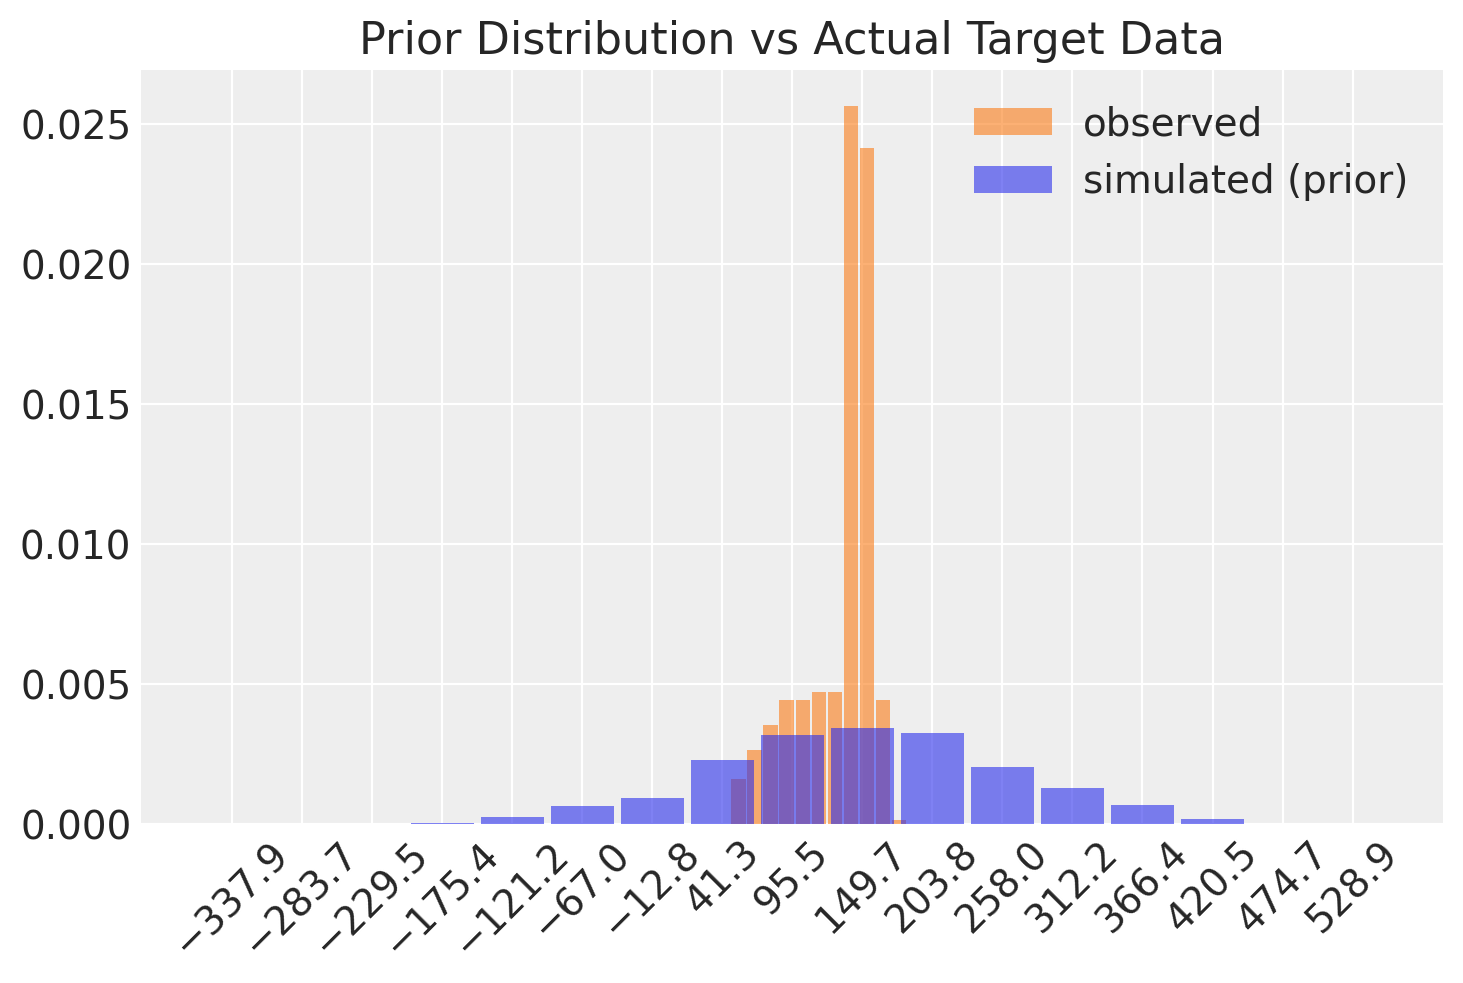

In [9]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [10]:
with model_poly:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [height]


## Model Parameters

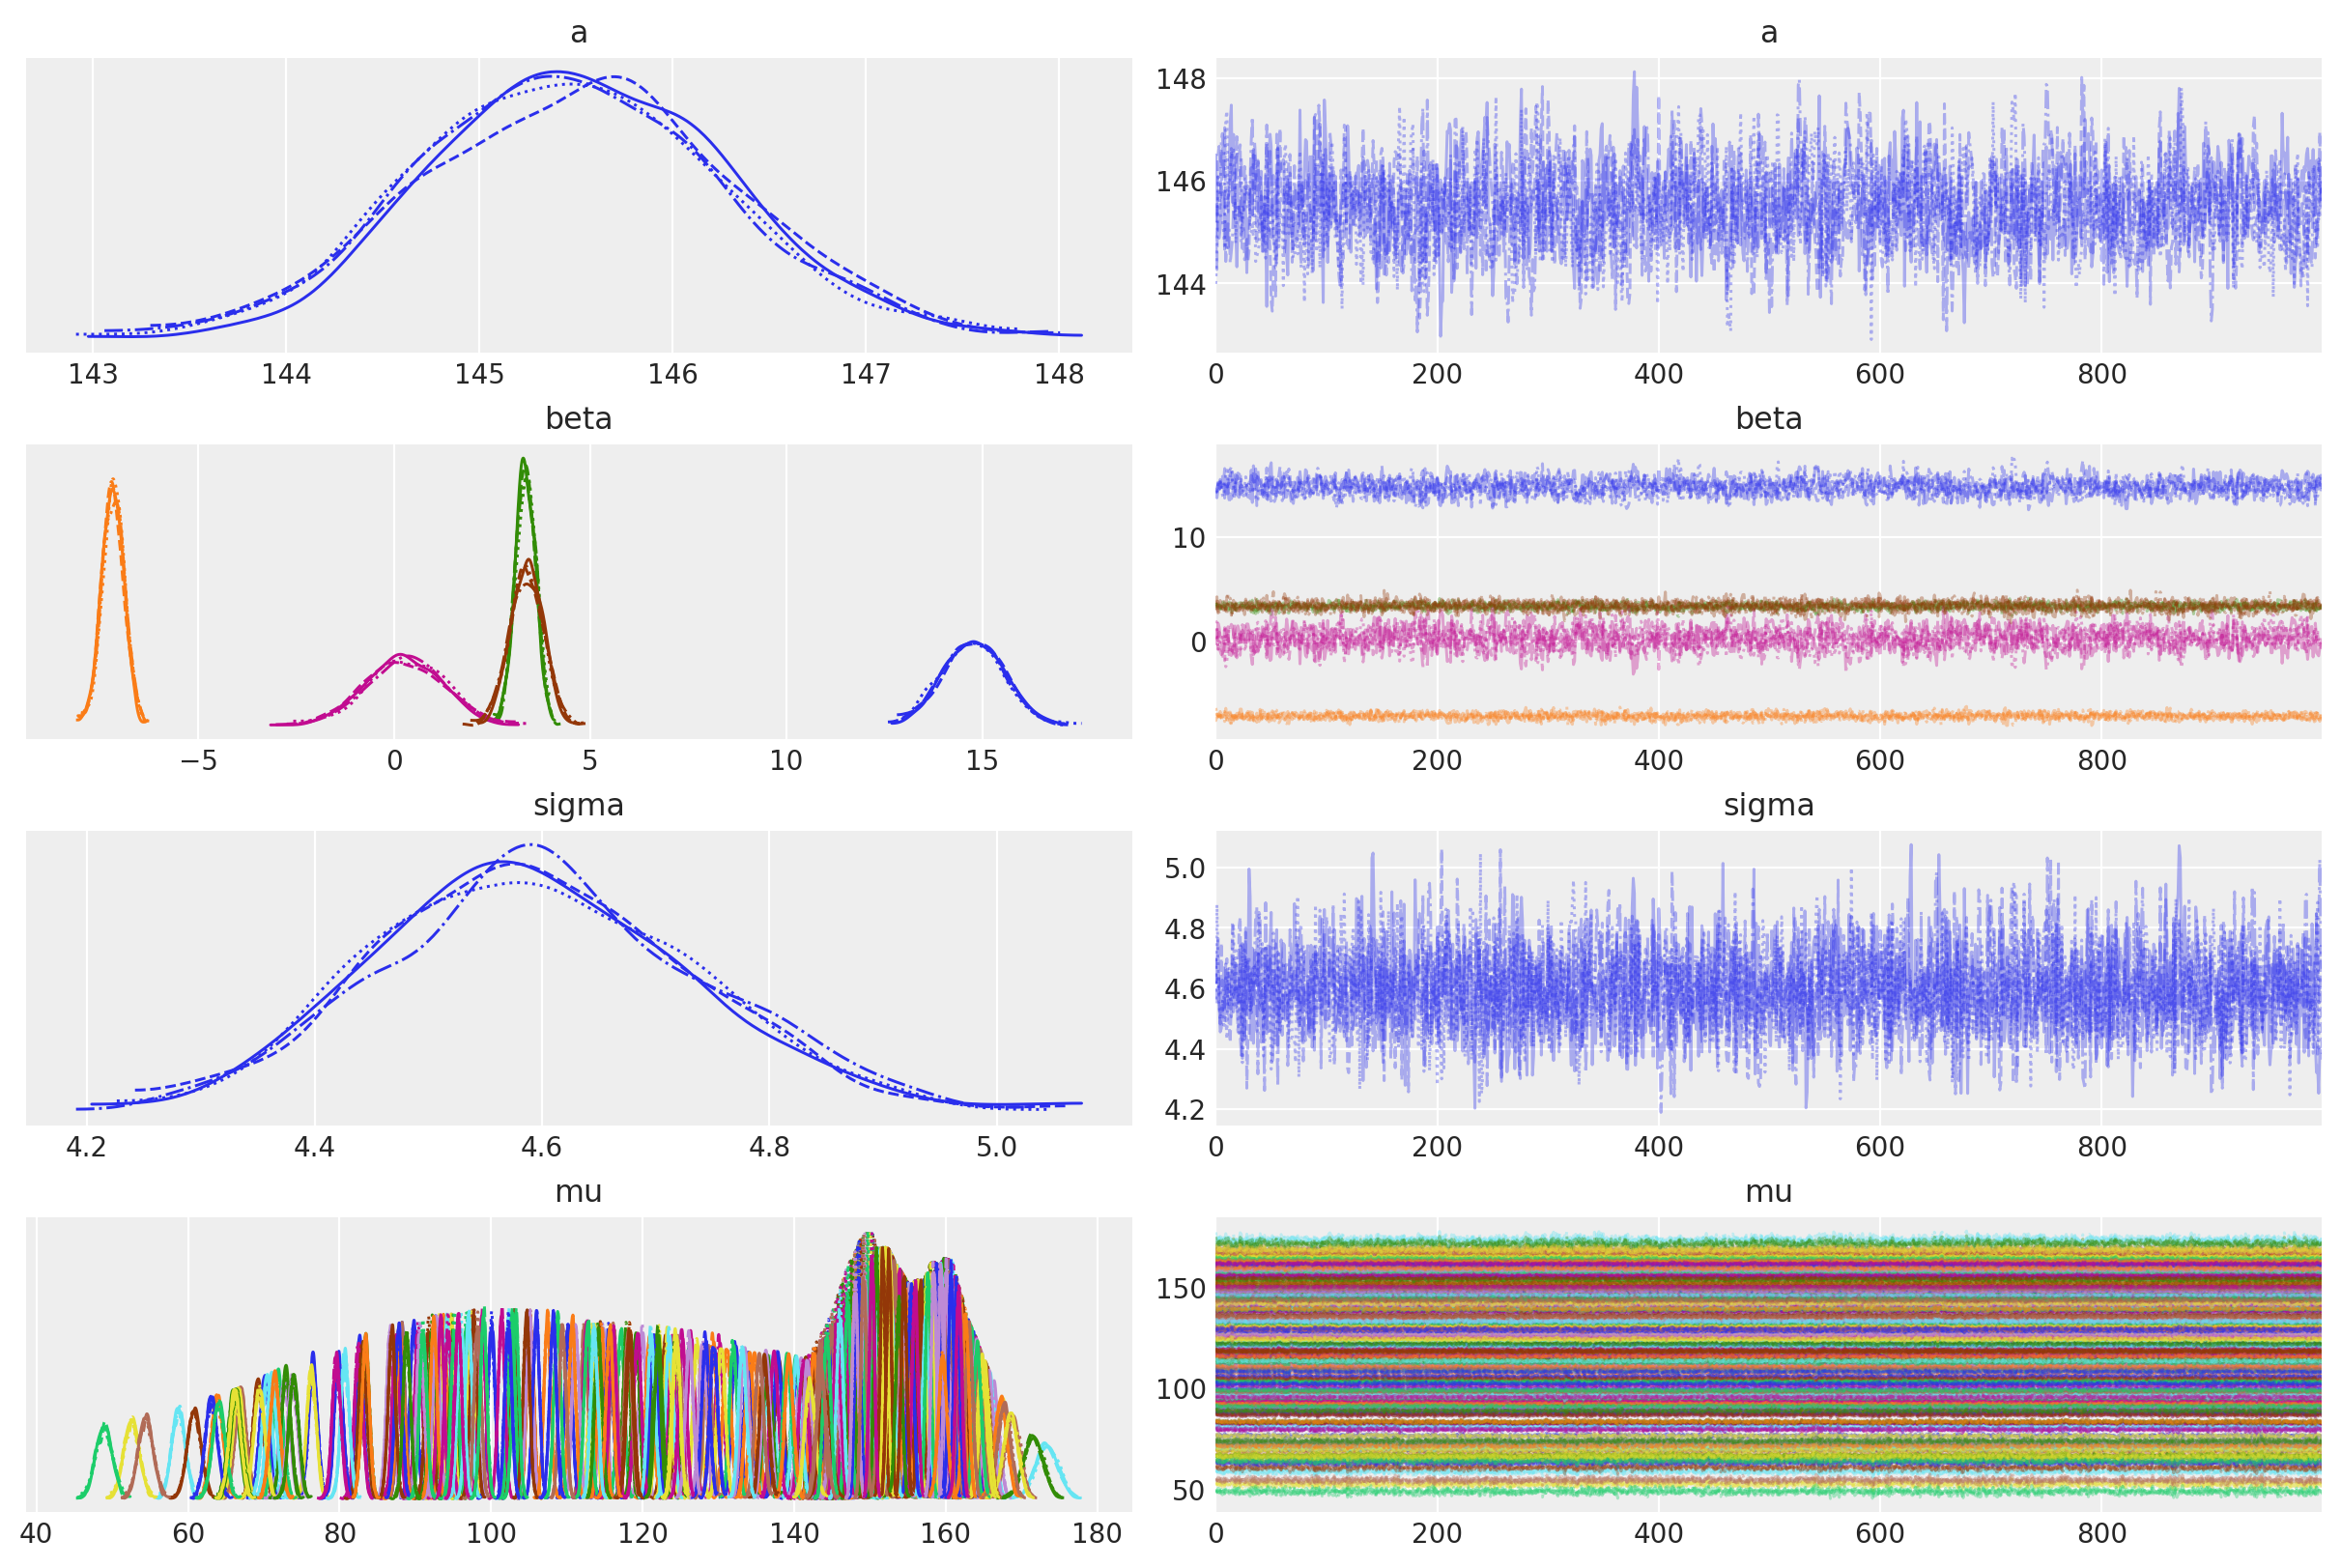

In [11]:
az.plot_trace(idata_posterior);

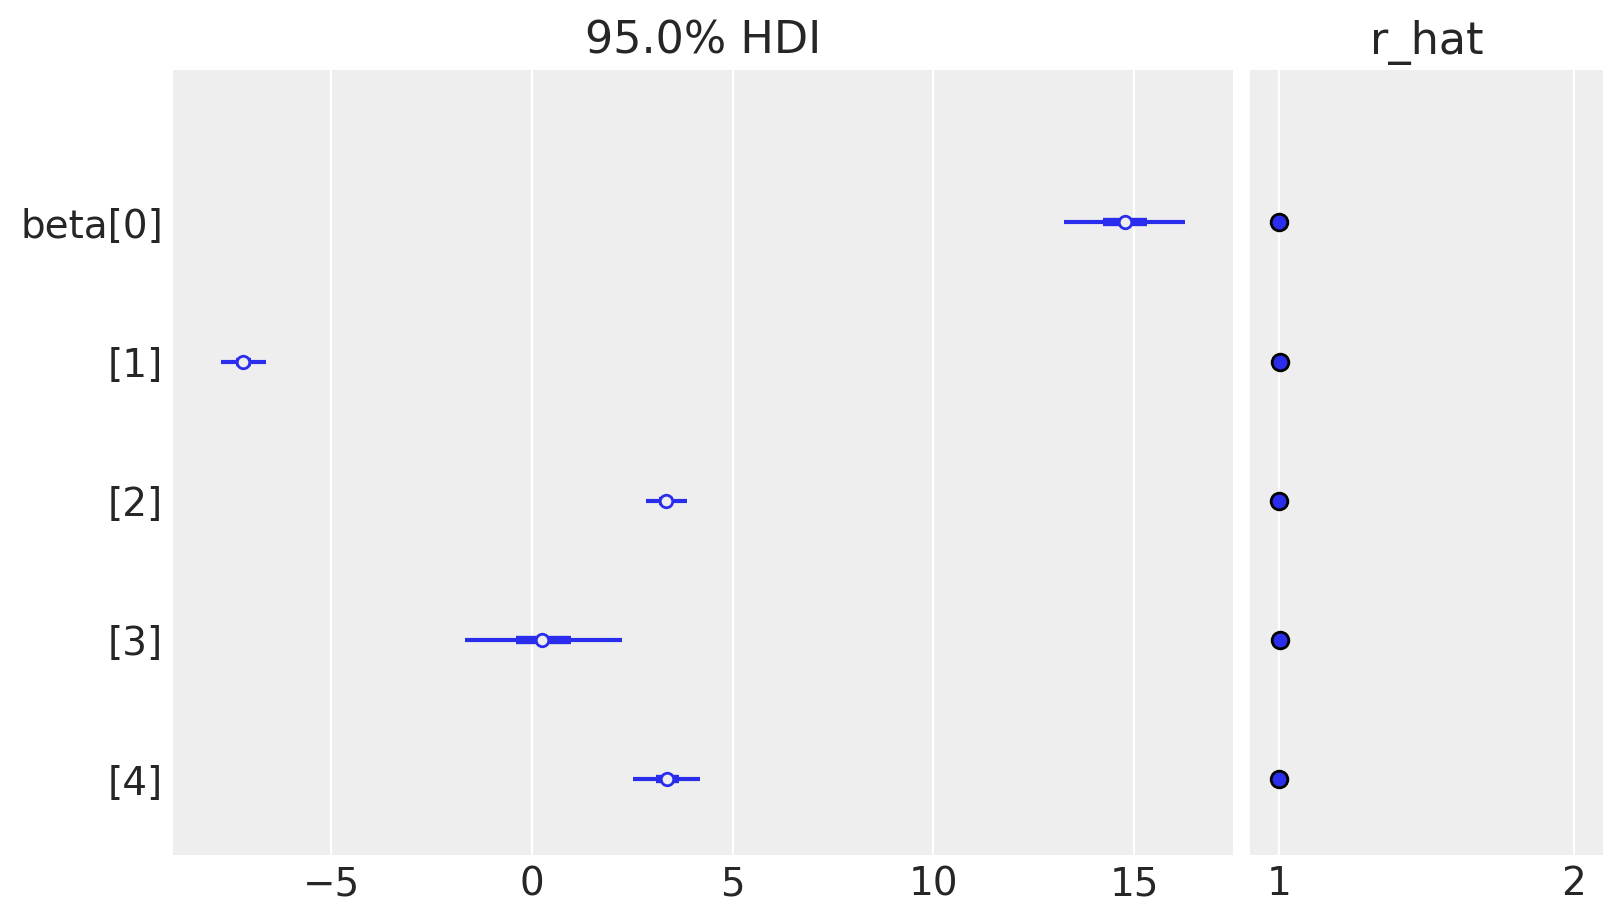

In [12]:
az.plot_forest(idata_posterior, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [13]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a        145.490  0.792  144.131  147.113
beta[0]   14.778  0.781   13.249   16.159
beta[1]   -7.182  0.286   -7.695   -6.624
beta[2]    3.341  0.262    2.846    3.819
beta[3]    0.270  1.003   -1.618    2.131
...          ...    ...      ...      ...
mu[539]  143.594  0.628  142.470  144.826
mu[540]  161.430  0.379  160.706  162.128
mu[541]  159.595  0.577  158.543  160.760
mu[542]   73.952  0.667   72.744   75.226
mu[543]  161.716  0.389  160.981  162.442

[551 rows x 4 columns]

### Comparison w/ `statsmodels` linear regression

In [14]:
import statsmodels.api as sm

ols_x = data.drop(columns='height')
ols_y = data['height']

ols_x = pipeline.transform(ols_x)

ols_x = sm.add_constant(ols_x)
ols_model = sm.OLS(ols_y, ols_x).fit() 
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3829.
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:49:32   Log-Likelihood:                -1597.2
No. Observations:                 544   AIC:                             3206.
Df Residuals:                     538   BIC:                             3232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.5658      0.779    186.842      0.0

In [15]:
import plotly_express as px

ols_predictions = ols_model.predict(ols_x)
temp = data.copy()
temp['sex'] = temp['male'].apply(lambda x: 'male' if x else 'female')
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights (OLS)"] = ols_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights (OLS)",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction (OLS)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0], row='all', col='all', exclude_empty_subplots=True)
fig


---

## Target Variable

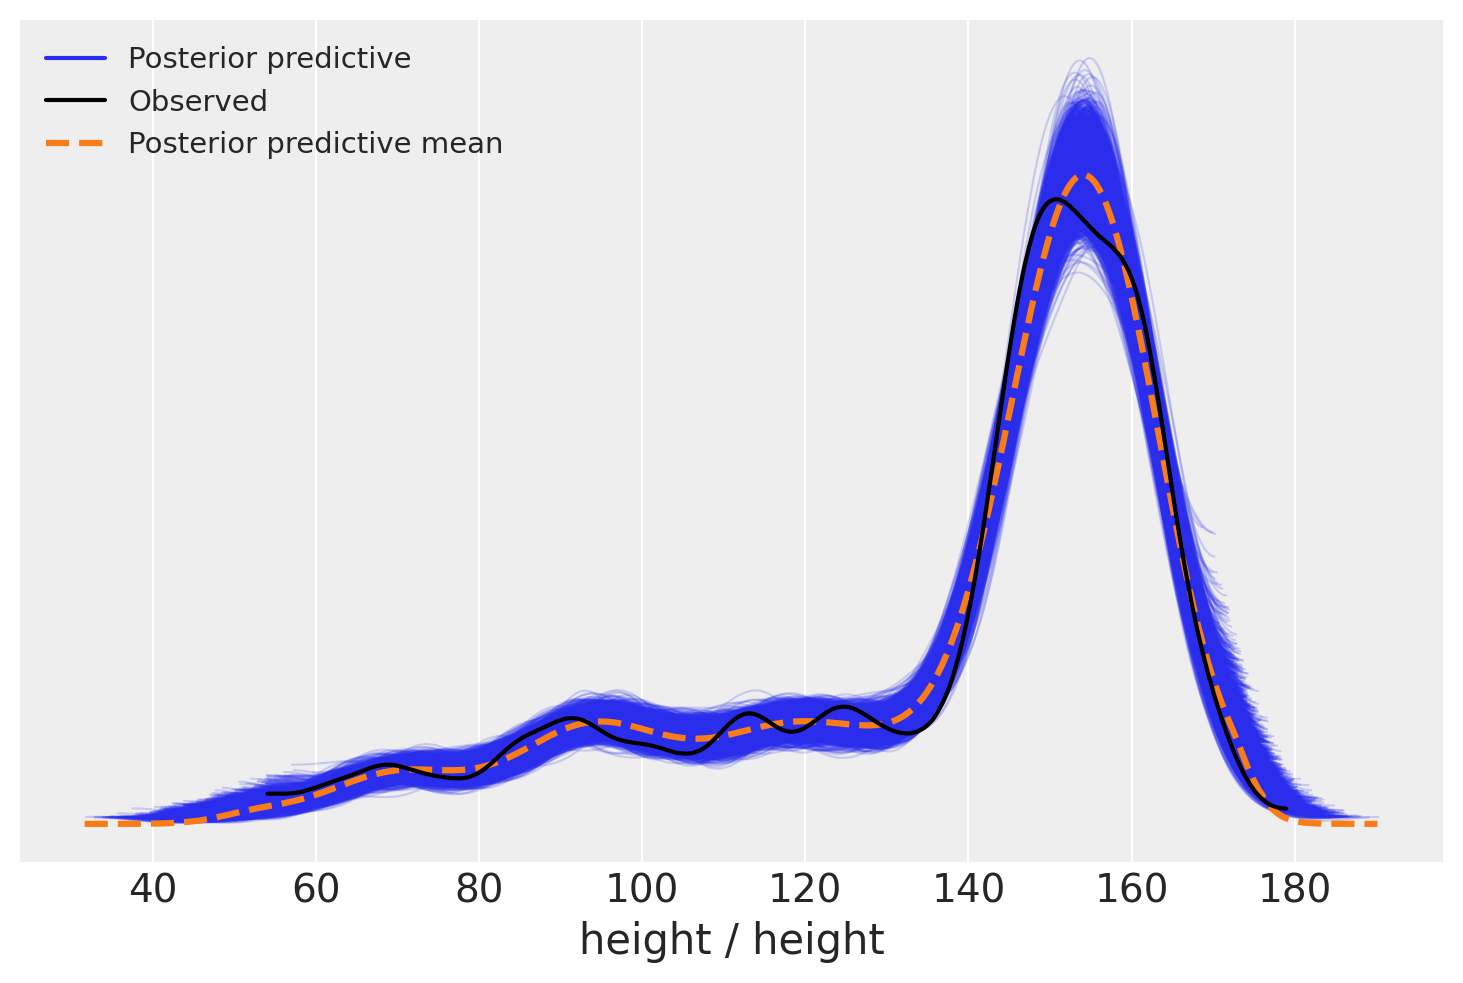

In [16]:
az.plot_ppc(idata_predictive);

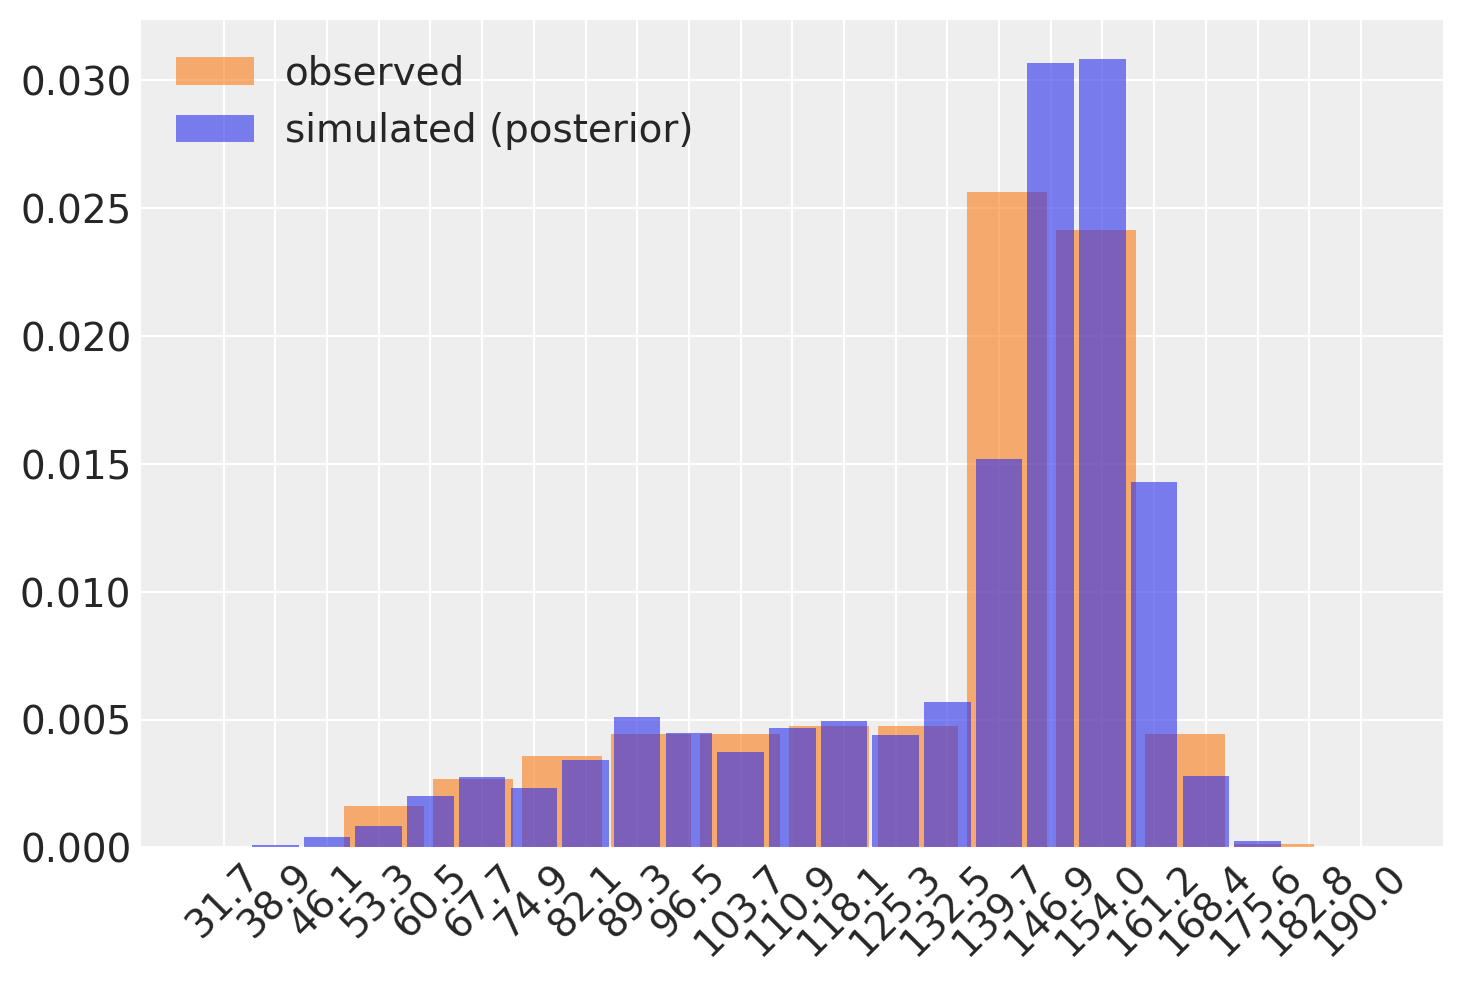

In [17]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [18]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(544, 4000)

In [19]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

31.680041024759596
190.4238718990769


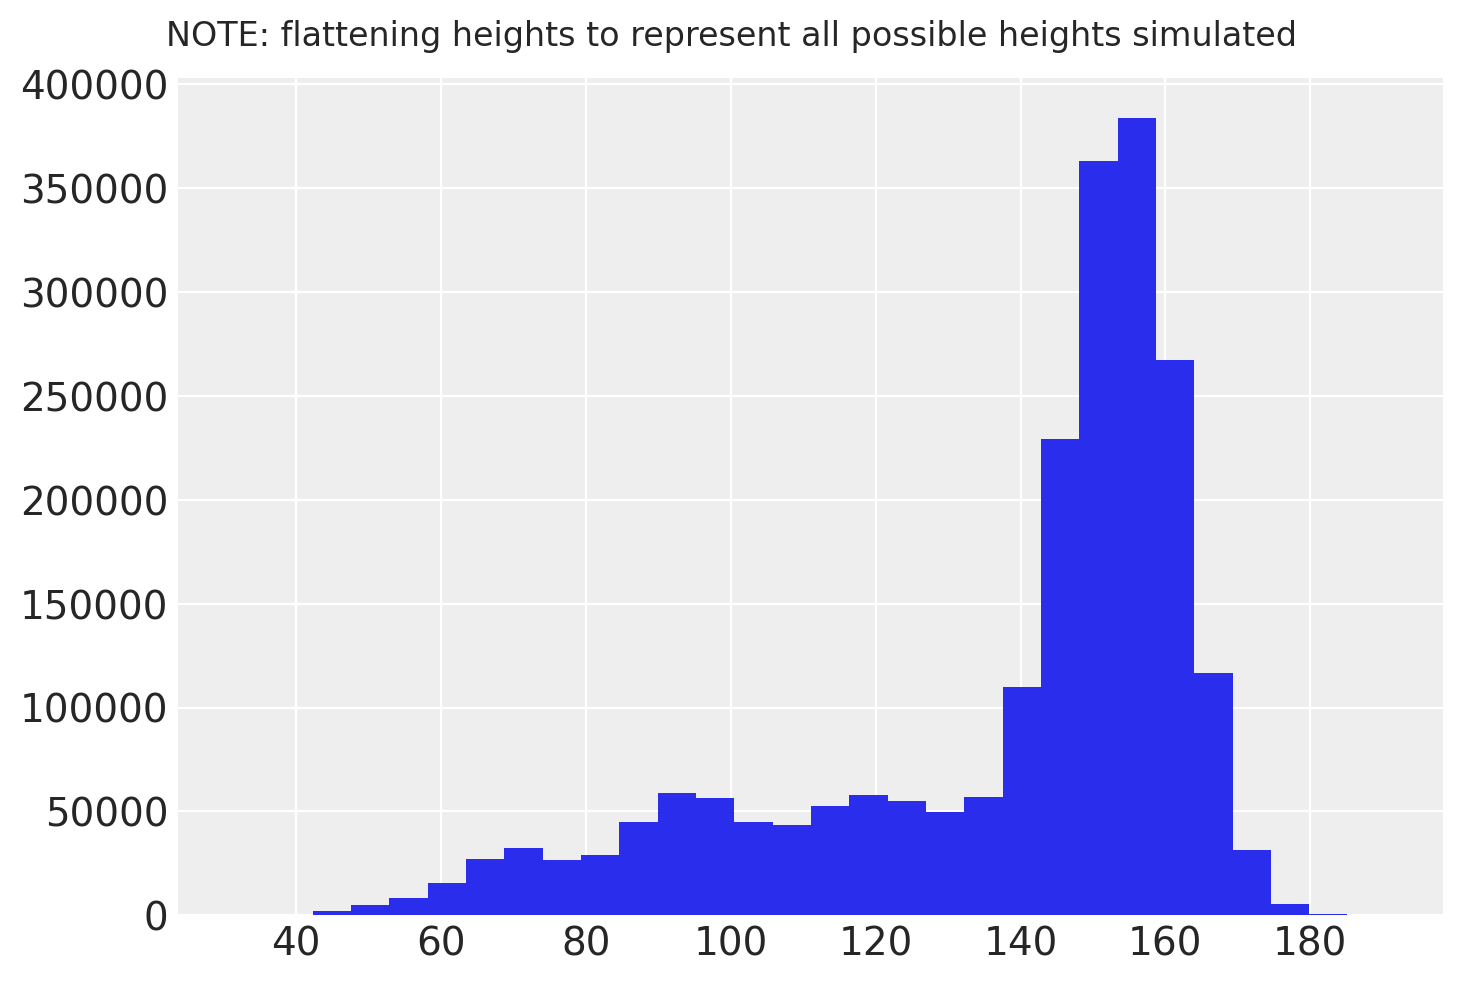

In [20]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [21]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

48.95038630925943
173.2364660880475


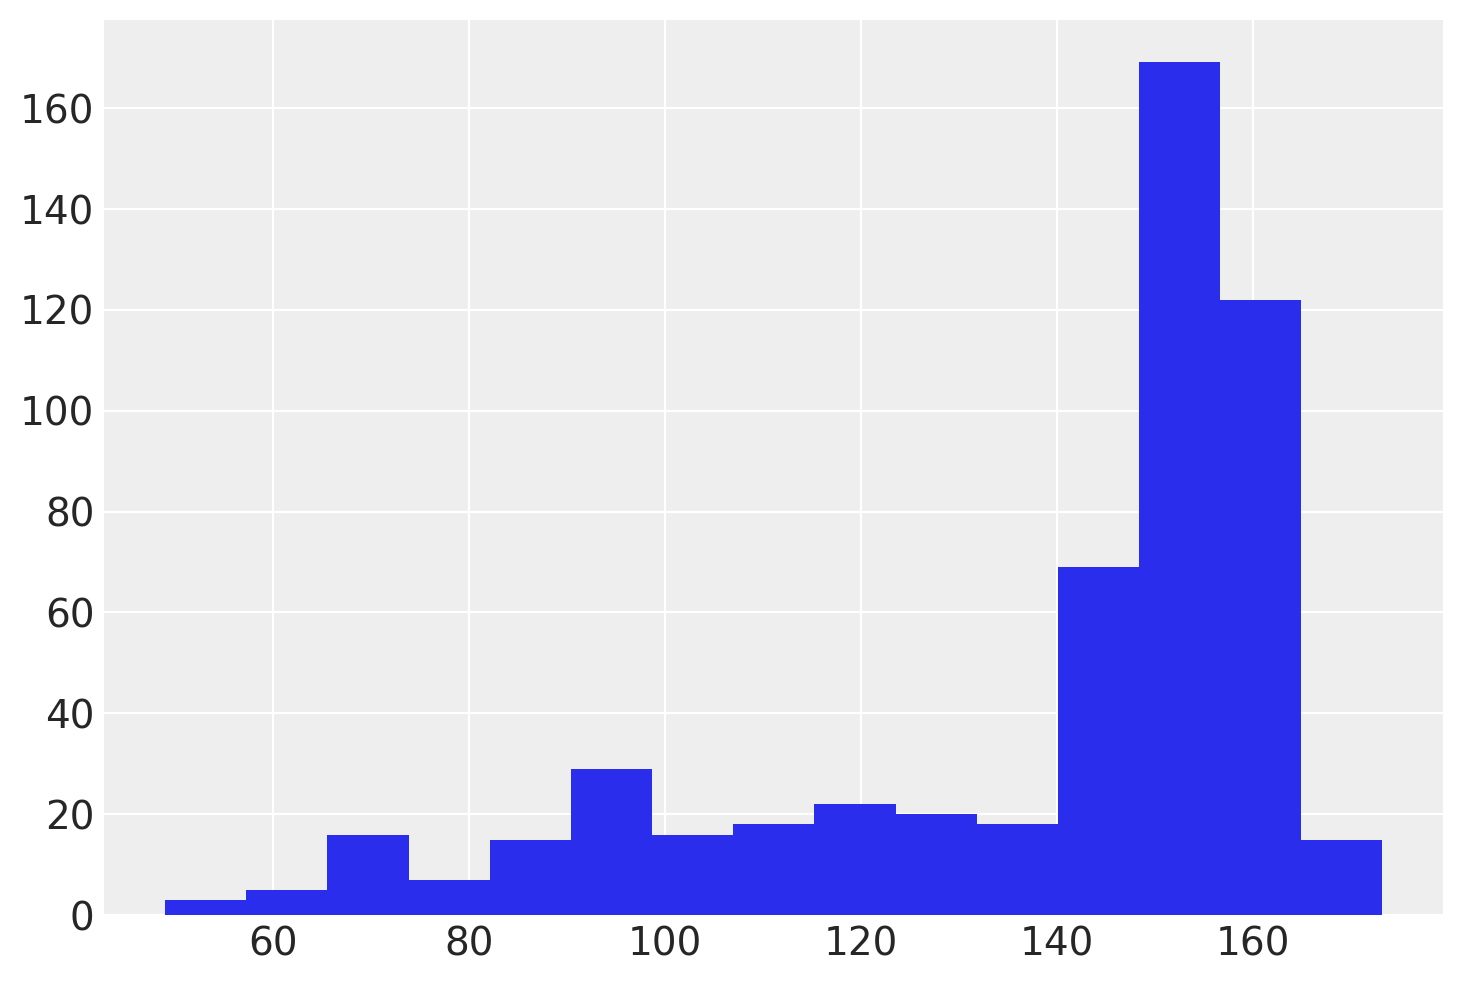

In [22]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [23]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a        145.490  0.792  144.131  147.113
beta[0]   14.778  0.781   13.249   16.159
beta[1]   -7.182  0.286   -7.695   -6.624
beta[2]    3.341  0.262    2.846    3.819
beta[3]    0.270  1.003   -1.618    2.131
...          ...    ...      ...      ...
mu[539]  143.594  0.628  142.470  144.826
mu[540]  161.430  0.379  160.706  162.128
mu[541]  159.595  0.577  158.543  160.760
mu[542]   73.952  0.667   72.744   75.226
mu[543]  161.716  0.389  160.981  162.442

[551 rows x 4 columns]

In [24]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning:

Selecting first found group: posterior_predictive



mean     sd   hdi_3%  hdi_97%
height[0]    158.444  4.595  150.110  167.310
height[1]    146.808  4.479  138.462  155.215
height[2]    141.329  4.507  133.131  149.997
height[3]    162.122  4.692  153.558  170.914
height[4]    150.532  4.617  142.152  159.211
...              ...    ...      ...      ...
height[539]  143.661  4.697  135.125  152.529
height[540]  161.384  4.570  153.026  170.187
height[541]  159.657  4.608  151.517  168.642
height[542]   73.981  4.589   65.938   83.050
height[543]  161.560  4.661  152.707  170.220

[544 rows x 4 columns]

In [25]:
posterior_target_samples = ph.get_posterior_samples(idata_predictive)
posterior_target_point_predictions = np.median(posterior_target_samples, axis=1)
assert posterior_target_samples.shape[0] == len(posterior_target_point_predictions)

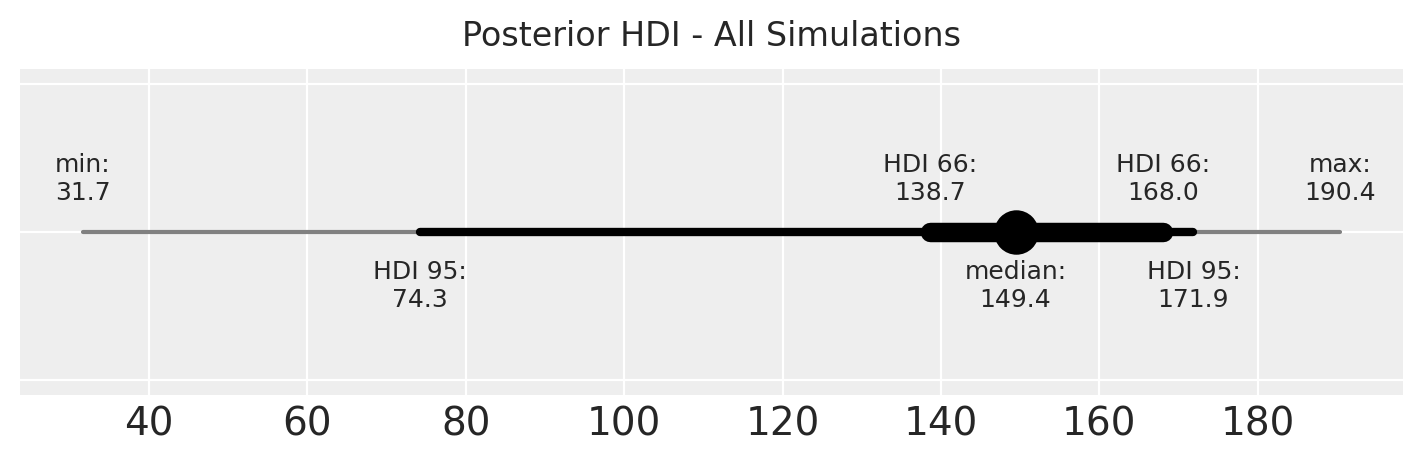

In [47]:
from helpsk.string import format_number

samples_flattened = posterior_target_samples.flatten()
plot.plot_hdi(
    samples_flattened,
    title=("Posterior HDI - All Simulations")
)

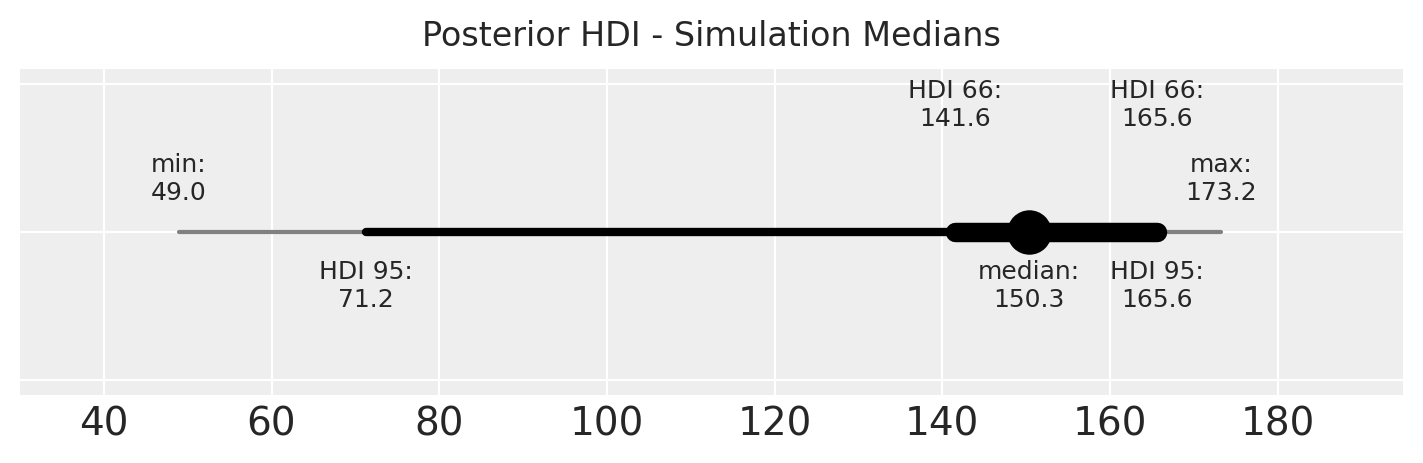

In [49]:
from helpsk.string import format_number

plot.plot_hdi(
    posterior_target_point_predictions,
    vertical_factor_66=2,
    title=("Posterior HDI - Simulation Medians"),
)
plt.xlim((30, 195));

## Actual vs Predicted

In [51]:
import plotly_express as px

temp = data.copy()
temp.rename(columns={'height': 'Actual Heights'}, inplace=True)
temp['sex'] = temp['male'].apply(lambda x: 'male' if x else 'female')
temp['Predicted Heights'] = posterior_target_point_predictions
temp['Residuals'] = temp['Predicted Heights'] - temp['Actual Heights']

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title=plot.px_title("Actual vs Prediction", "red line is perfect fit; blue line is actual fit")
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0], row='all', col='all', exclude_empty_subplots=True)
fig


## Residuals

In [29]:
fig = px.histogram(
    temp,
    x="Residuals",
    facet_col='sex',
    title="Residuals (Predicted - Actual)<br><sup>red line is perfect fit</sup>",
)
fig.add_vline(x=0, line_width=3, line_color="red")
fig

In [52]:
fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Residuals",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title=plot.px_title(
        "Actual vs Residual (Predicted - Actual)",
        "red line is perfect fit; blue line is actual fit"
    )
)
fig.add_hline(y=0, line_width=3, line_color="red")
fig


---

# New Predictions

In [31]:
new_data = pd.DataFrame(dict(
    weight=[10, 20, 30, 40],
    age=[10, 20, 30, 40],
    male=[1, 0, 0, 0],
))
new_data = pipeline.transform(new_data)
print(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data
)
prediction_sims

Sampling: [height]


[[-1.74155031  3.03299747 -5.28211767  0.          1.        ]
 [-1.06153925  1.12686558 -1.19621205  1.          0.        ]
 [-0.3815282   0.14556377 -0.05553668  1.          0.        ]
 [ 0.29848286  0.08909202  0.02659244  1.          0.        ]]


array([[ 86.82975612,  75.41402948,  89.58233517, ...,  76.90501174,
         84.93485419,  84.05151524],
       [119.06873825, 125.86477202, 117.53985135, ..., 113.82799541,
        117.89730139, 120.11315125],
       [140.94814197, 140.35666292, 141.09183067, ..., 142.76791776,
        142.24189501, 144.98399001],
       [156.74059652, 144.45811831, 145.74053059, ..., 154.58839404,
        146.28593431, 159.72869906]])

In [32]:
np.median(prediction_sims, axis=1)

array([ 83.80714471, 118.04210782, 138.9268461 , 149.50724724])

---

## What is the difference in the **expected** or **predicted** height for any given set of individuals between men and women at age 20 across all weights from 30 to 60?

In [33]:
sim_weights = np.repeat(np.arange(30, 61), 2)
print(sim_weights)


[30 30 31 31 32 32 33 33 34 34 35 35 36 36 37 37 38 38 39 39 40 40 41 41
 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49 50 50 51 51 52 52 53 53
 54 54 55 55 56 56 57 57 58 58 59 59 60 60]


In [34]:
sim_age = np.repeat(20, len(sim_weights))
assert len(sim_age) == len(sim_weights)
print(sim_age)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20]


In [35]:
sim_sex = np.tile(np.arange(0, 2), int(len(sim_weights) / 2))
assert len(sim_sex) == len(sim_weights)
print(sim_sex)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [36]:
new_data = pd.DataFrame(dict(
    weight=sim_weights,
    age=sim_age,
    male=sim_sex,
))
new_data.head()

weight  age  male
0      30   20     0
1      30   20     1
2      31   20     0
3      31   20     1
4      32   20     0

In [37]:
new_data = pipeline.transform(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data,
)
assert prediction_sims.shape[0] == len(sim_weights);

Sampling: [height]


### Looks at results only for age 30 (i.e. first and second row, first row is female, second is male)

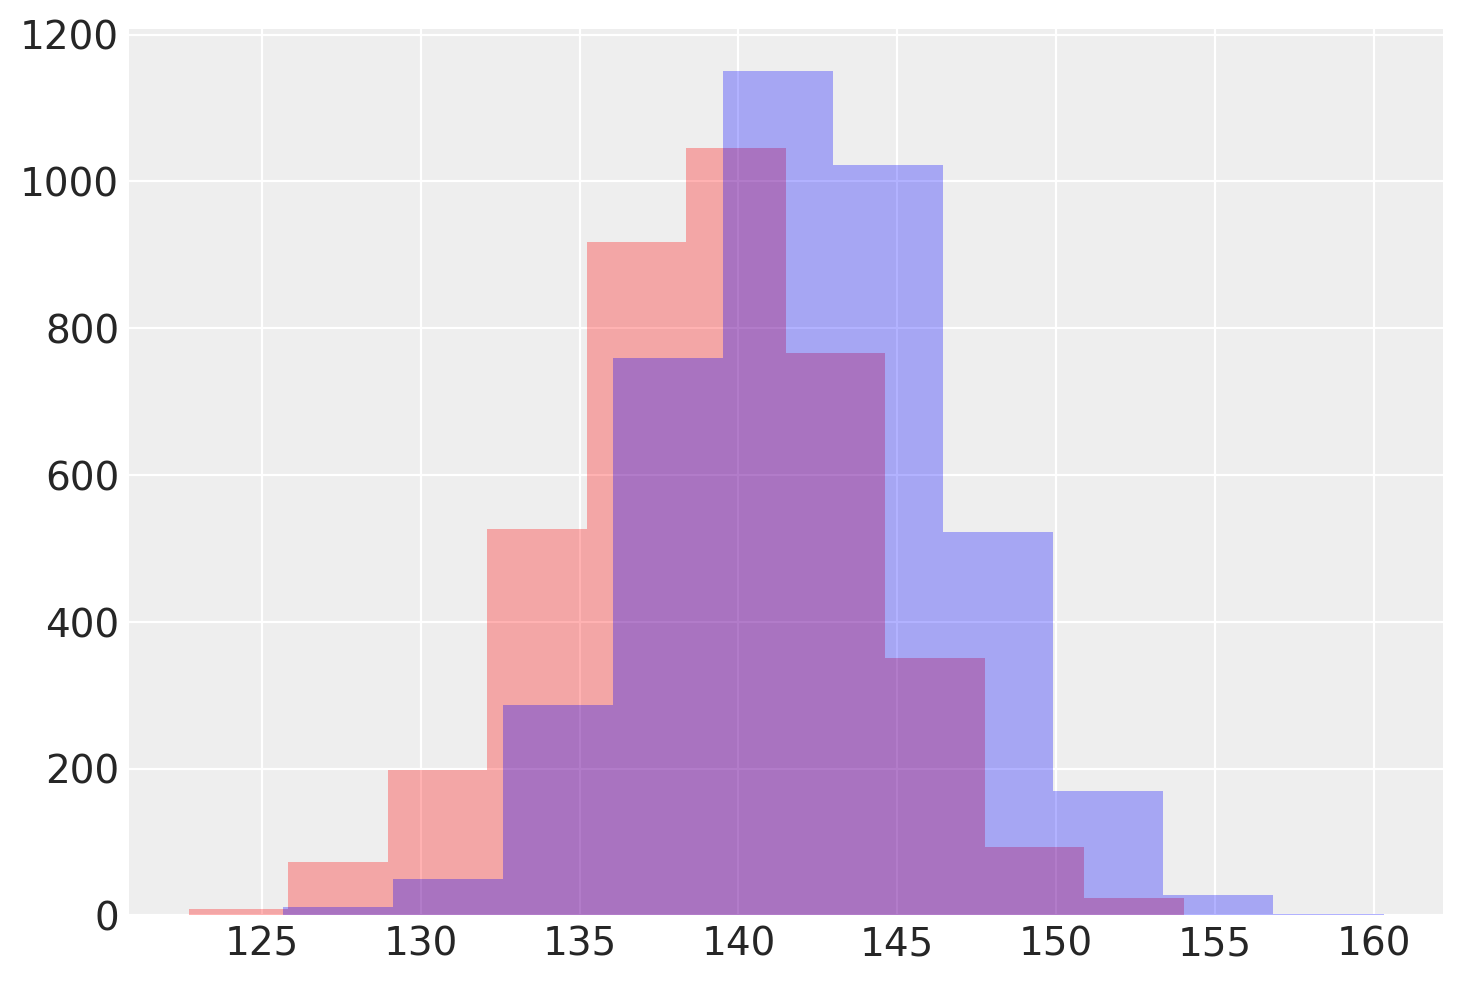

In [38]:
plt.hist(prediction_sims[0, :], color='red', alpha=0.3)
plt.hist(prediction_sims[1, :], color='blue', alpha=0.3);

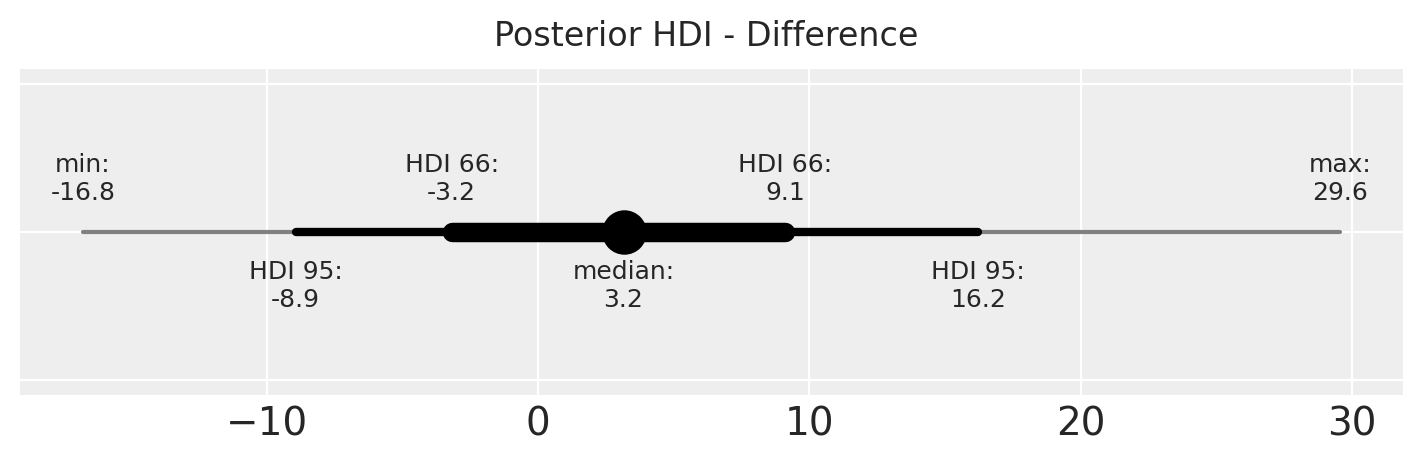

In [53]:
# male - female sims at weight 30
samples = prediction_sims[1, :] - prediction_sims[0, :]
plot.plot_hdi(
    samples,
    title="Posterior HDI - Difference "
)

In [40]:
print(np.median(prediction_sims[0, :]))
print(np.median(prediction_sims[1, :]))
# should always take mean/median after you take difference in distribution
print(np.median(prediction_sims[1, :] - prediction_sims[0, :]))

139.13937371901153
142.28737763220772
3.1522559180101553


On average the expected height of a male and female at age 20 with a weight of `30` is `3.35`, but can likely (95% hdi) range anywhere from the male being 9cm (3.5 inches) shorter to 16 (6.3 inches) taller, with the average male being 142cm. Remember we are dealing with the low end of weight

In [41]:
np.mean((prediction_sims[1, :] - prediction_sims[0, :]) > 0)

0.68775

70% of our simulations are greater than 1 i.e. There is a 70% probability that any given male will be taller than any given female, weighting each weighing `30kg`, given the assumptions of this model.

---